### Full - Baseline : Traditional Time Series Model (ES, AR, SARIMA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_data(dataset):
    data = pd.read_csv(f'./data/{dataset}_MRR.csv')
    mrr_data = data['MRR']
    mrr_train = mrr_data[:int(len(mrr_data) * 0.7)]
    mrr_test = mrr_data[int(len(mrr_data) * 0.7):] 

    return mrr_train, mrr_test

In [3]:
# print the amount of data
A456_train, A456_test = get_data('A456')
print('A456_train :', A456_train.shape[0])
print('A456_test : ', A456_test.shape[0])

B456_train, B456_test = get_data('B456')
print('B456_train :', B456_train.shape[0])
print('B456_test : ', B456_test.shape[0])

A456_train : 674
A456_test :  289
B456_train : 700
B456_test :  301


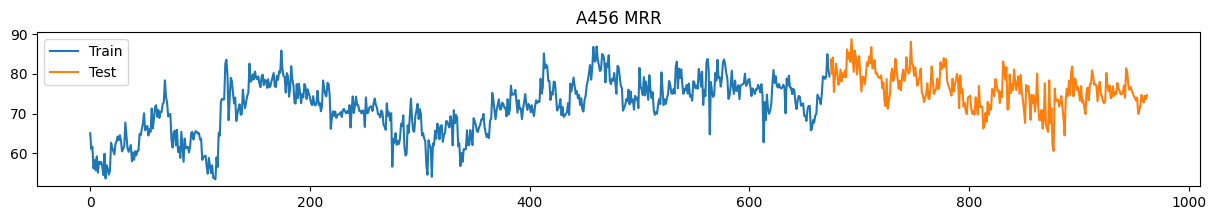

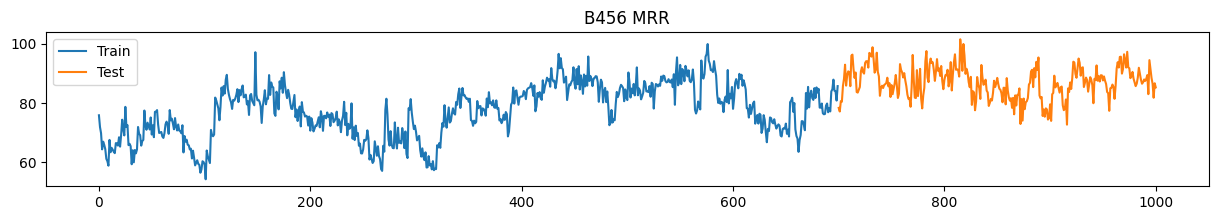

In [4]:
# plot the series after split
plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(A456_train.shape[0]), A456_train.tolist(), label='Train')
plt.plot(range(A456_train.shape[0], A456_train.shape[0] + A456_test.shape[0]), A456_test.tolist(), label='Test')
plt.title('A456 MRR')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(B456_train.shape[0]), B456_train.tolist(), label='Train')
plt.plot(range(B456_train.shape[0], B456_train.shape[0] + B456_test.shape[0]), B456_test.tolist(), label='Test')
plt.title('B456 MRR')
plt.legend(loc='upper left')
plt.show()

Exponential Smoothing

In [ ]:
def es_model(train, test, title, seasonal=False):
    
    train = train.to_list()
    test = test.to_list()
    
    # 初始化模型的訓練數據
    rolling_train = train.copy()

    # 保存滾動預測結果
    es_pred = []

    # 滾動預測過程
    for actual in test:
        # 使用當前訓練數據擬合模型
        if seasonal:
            model = ExponentialSmoothing(rolling_train, trend='add', seasonal="mul", seasonal_periods=25)
        else:
            model = ExponentialSmoothing(rolling_train, trend='add', seasonal=None)
        fit = model.fit()
        
        # 預測下一步
        forecast = fit.forecast(steps=1)[0]
        es_pred.append(forecast)
        
        # 將當前真實值加入訓練數據
        rolling_train.append(actual)

    # calculate the MSE
    mse = mean_squared_error(test, es_pred)
    print(f'{title} MSE :', round(mse, 3))

    # plot the result
    plt.figure(figsize=(15, 2), dpi=100)
    plt.plot(train, label='Train')
    plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
    plt.plot(range(len(train), len(train) + len(es_pred)), es_pred, label='Pred')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()


A456 MSE : 10.736


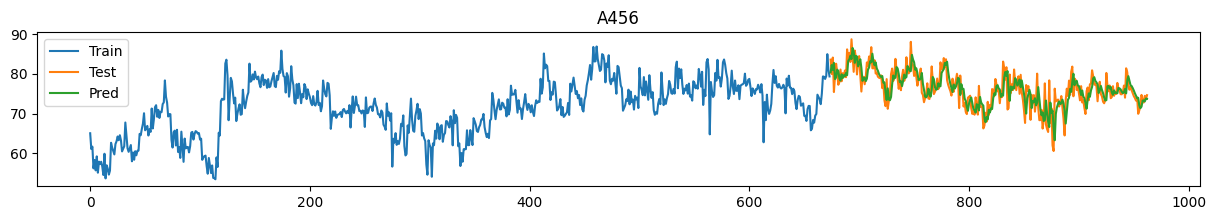

B456 MSE : 15.354


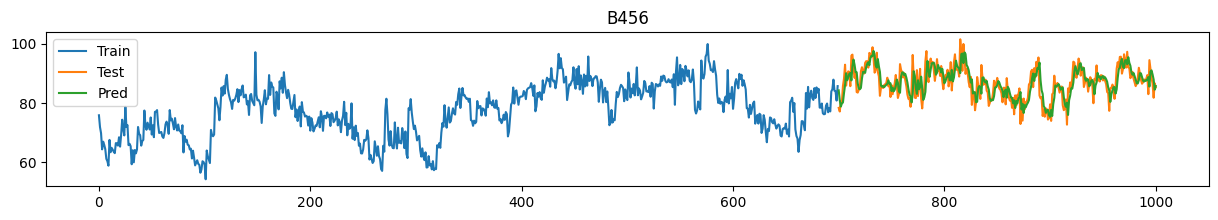

In [ ]:
# Exponential Smoothing
es_model(A456_train, A456_test, 'A456')
es_model(B456_train, B456_test, 'B456')

A456 MSE : 11.127


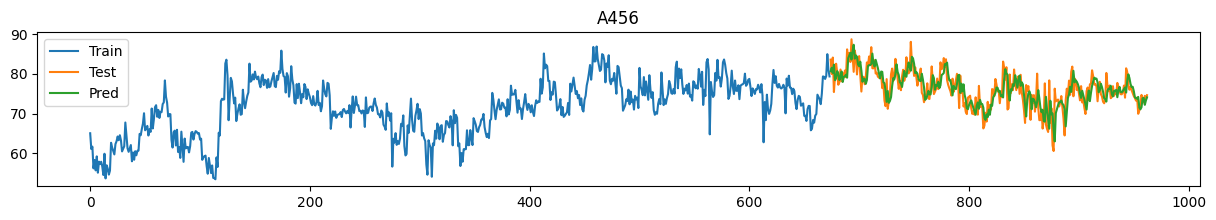

B456 MSE : 15.564


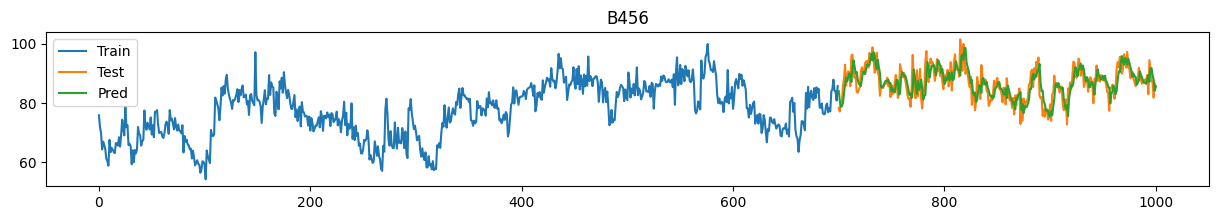

In [ ]:
# Exponential Smoothing(25)
es_model(A456_train, A456_test, 'A456', seasonal=True)
es_model(B456_train, B456_test, 'B456', seasonal=True)

AR model

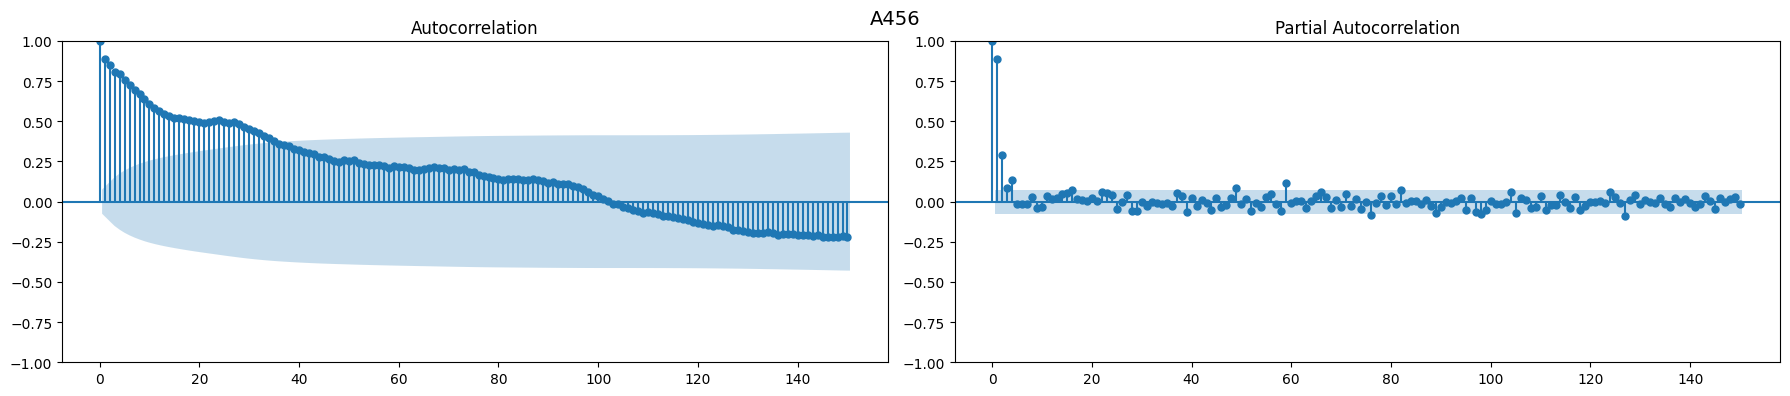

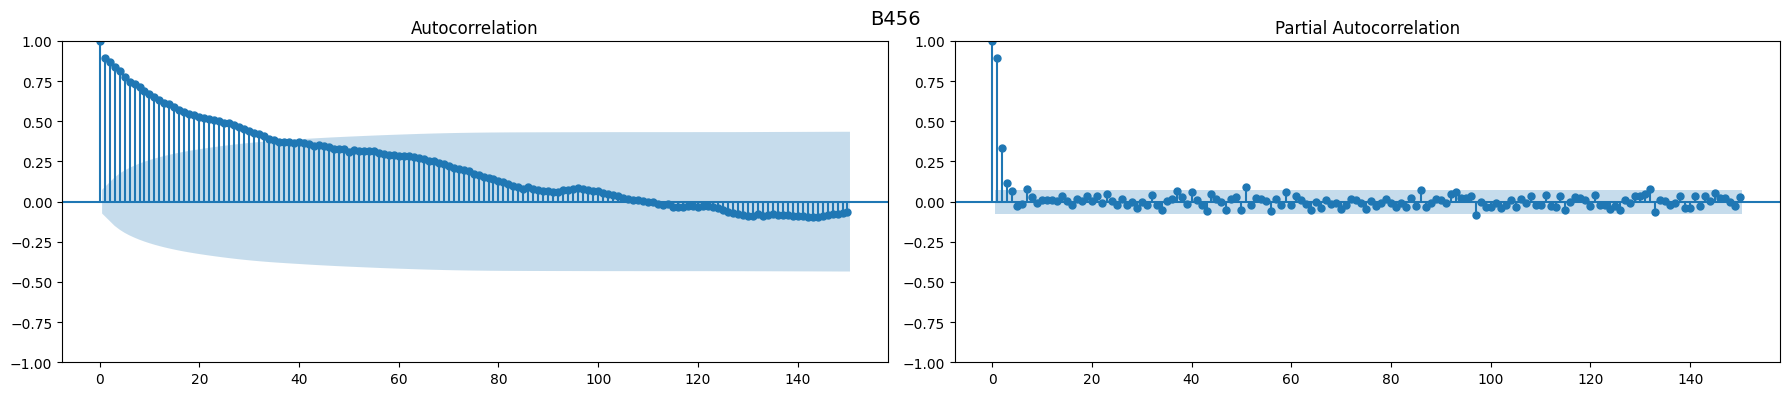

In [ ]:
# plot ACF and PACF
def plot_ACF_PACF(data, title):

    plt.figure(figsize=(18, 4), dpi=100)

    # ACF
    plt.subplot(1, 2, 1)
    plot_acf(data, lags=150, ax=plt.gca())

    # PACF
    plt.subplot(1, 2, 2)
    plot_pacf(data, lags=150, ax=plt.gca())

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(title, fontsize=14)
    plt.show()

plot_ACF_PACF(A456_train, 'A456')
plot_ACF_PACF(B456_train, 'B456')

In [ ]:
# use auto_arima funciton to select best AR model
def ar_selecting(train):
    autoarima = auto_arima(
        train,
        start_p=0,
        start_q=0,
        d=0,
        max_p=5,
        max_q=5,
        m=25,  # seasonal
        out_of_sample_size=10,
        suppress_warnings=True,
        rolling=True,
        error_action='ignore')

    print(autoarima.summary())

print('A456 best AR')
ar_selecting(A456_train)
print('B456 best AR')
ar_selecting(B456_train)

A456 best AR
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  674
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -1683.566
Date:                Thu, 21 Nov 2024   AIC                           3379.133
Time:                        01:03:26   BIC                           3406.212
Sample:                             0   HQIC                          3389.619
                                - 674                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2581      1.231      3.458      0.001       1.845       6.671
ar.L1          0.5766      0.037     15.466      0.000       0.504       0.650
ar.L2          0.2014      0.046      4

In [ ]:
# we select the AR(4) for both A456 and B456
def ar_model(train, test, title):
    # fit the model
    ar = ARIMA(order=(4, 0, 0))
    ar_model = ar.fit(train)
    print(ar_model.summary())

    # rolling forecasting
    rolling_preds = []
    first_pred = ar_model.predict(n_periods=1)
    rolling_preds.append(first_pred)
    for i in list(test.index)[:-1]:
        ar_model.update(test[i])
        new_preds = ar_model.predict(n_periods=1)
        rolling_preds.append(new_preds)

    # calculate the MSE
    mse = mean_squared_error(test, rolling_preds)
    print('MSE :', round(mse, 3))

    # plot the result
    plt.figure(figsize=(15, 2), dpi=100)
    plt.plot(train, label='Train')
    plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
    plt.plot(range(len(train),
                   len(train) + len(rolling_preds)),
             rolling_preds,
             label='Pred')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  674
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -1683.560
Date:                Thu, 28 Nov 2024   AIC                           3379.120
Time:                        16:22:38   BIC                           3406.200
Sample:                             0   HQIC                          3389.606
                                - 674                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.1186      1.232      3.344      0.001       1.705       6.533
ar.L1          0.5773      0.037     15.484      0.000       0.504       0.650
ar.L2          0.2020      0.046      4.432      0.0

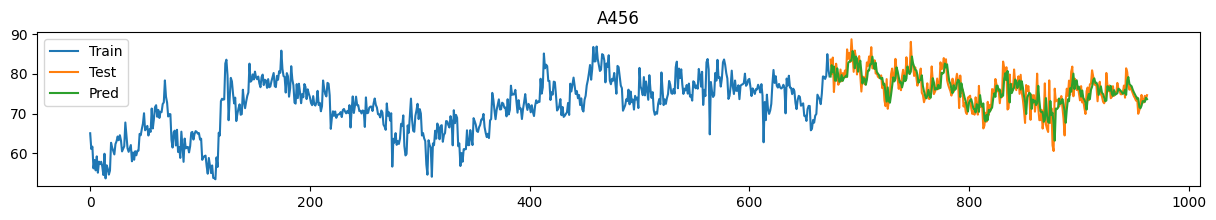

In [ ]:
ar_model(A456_train, A456_test, 'A456')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -1893.796
Date:                Thu, 28 Nov 2024   AIC                           3799.593
Time:                        16:23:12   BIC                           3826.899
Sample:                             0   HQIC                          3810.148
                                - 700                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4140      1.272      3.469      0.001       1.920       6.908
ar.L1          0.5480      0.035     15.700      0.000       0.480       0.616
ar.L2          0.2468      0.042      5.920      0.0

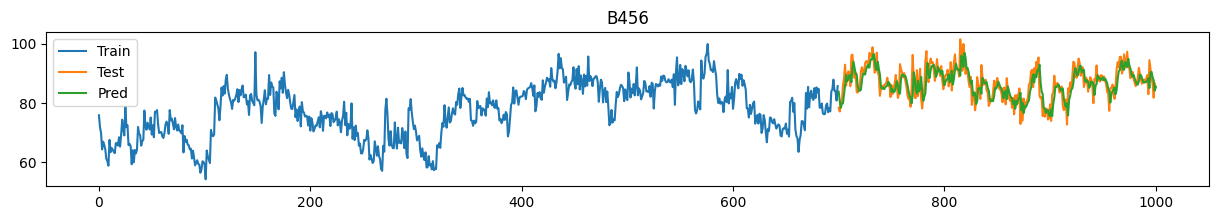

In [ ]:
ar_model(B456_train, B456_test, 'B456')

ARIMA model

In [15]:
# select the best ARIMA model by AIC and BIC
def get_arima_aic(data, p, stat=True):
    for i in range(1, p+1):
        model = ARIMA(order=(4, 0, 0), seasonal_order=(i, 0, 0, 25), enforce_stationary=stat)
        model.fit(data)
        print(f'SARIMA(4,0,0),({i},0,0,25) AIC:{round(model.aic(), 4)} BIC:{round(model.bic(), 4)}')
    
print('A456:')
get_arima_aic(A456_train, 4, True)
print('B456:')
get_arima_aic(B456_train, 4, False) # to avoid LU decomposition error

A456:
SARIMA(4,0,0),(1,0,0,25) AIC:3381.0137 BIC:3412.6063
SARIMA(4,0,0),(2,0,0,25) AIC:3382.9249 BIC:3419.0308
SARIMA(4,0,0),(3,0,0,25) AIC:3380.6767 BIC:3421.2958
SARIMA(4,0,0),(4,0,0,25) AIC:3382.6655 BIC:3427.7978
B456:
SARIMA(4,0,0),(1,0,0,25) AIC:3801.5923 BIC:3833.4499
SARIMA(4,0,0),(2,0,0,25) AIC:3796.6446 BIC:3833.0532
SARIMA(4,0,0),(3,0,0,25) AIC:3797.7041 BIC:3838.6638
SARIMA(4,0,0),(4,0,0,25) AIC:3799.5924 BIC:3845.1032


In [5]:
# we select the ARIMA(4,0,0),(2,0,0,25) for both A456 and B456
def arima_model(train, test, title):
    # fit the model
    ar = ARIMA(order=(4, 0, 0), seasonal_order=(2, 0, 0, 25))
    ar_model = ar.fit(train)
    print(ar_model.summary())

    # rolling forecasting
    rolling_preds = []
    first_pred = ar_model.predict(n_periods=1)
    rolling_preds.append(first_pred)
    for i in list(test.index)[:-1]:
        ar_model.update(test[i])
        new_preds = ar_model.predict(n_periods=1)
        rolling_preds.append(new_preds)

    # calculate the MSE
    mse = mean_squared_error(test, rolling_preds)
    print('MSE :', round(mse, 3))

    # plot the result
    plt.figure(figsize=(15, 2), dpi=100)
    plt.plot(train, label='Train')
    plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
    plt.plot(range(len(train),
                   len(train) + len(rolling_preds)),
             rolling_preds,
             label='Pred')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  674
Model:             SARIMAX(4, 0, 0)x(2, 0, 0, 25)   Log Likelihood               -1683.462
Date:                            Mon, 13 Jan 2025   AIC                           3382.925
Time:                                    20:43:53   BIC                           3419.031
Sample:                                         0   HQIC                          3396.906
                                            - 674                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.0967      1.223      3.351      0.001       1.701       6.493
ar.L1          0.5743      0.038   

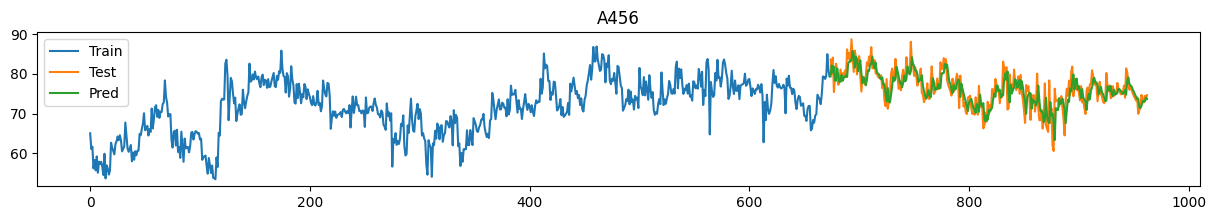

In [6]:
arima_model(A456_train, A456_test, 'A456')

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  700
Model:             SARIMAX(4, 0, 0)x(2, 0, 0, 25)   Log Likelihood               -1890.322
Date:                            Mon, 13 Jan 2025   AIC                           3796.645
Time:                                    21:25:18   BIC                           3833.053
Sample:                                         0   HQIC                          3810.719
                                            - 700                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4418      1.354      3.280      0.001       1.788       7.096
ar.L1          0.5573      0.035   

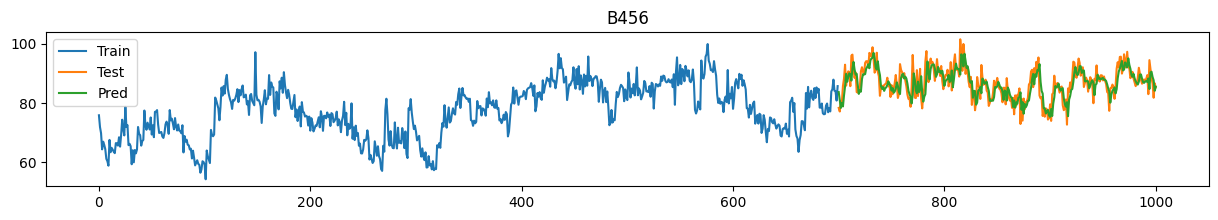

In [7]:
arima_model(B456_train, B456_test, 'B456')